In [1]:
import os
import glob
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm
import time
from scanpy.tools._utils import get_init_pos_from_paga 
from sklearn.metrics import mean_squared_error
import warnings

import torch
import rmm
import cupy
import cudf
import cupy as cp
from rmm.allocators.cupy import rmm_cupy_allocator
import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi

from cuml.manifold import UMAP
from cuml.decomposition import TruncatedSVD

# Enable `managed_memory`
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

from tqdm.notebook import tqdm

In [2]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/pseudotime.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 520 ms, sys: 4.69 s, total: 5.21 s
Wall time: 8.41 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

# Add new sample labels

sample_labels
0    1150
4    1149
5    1149
2    1149
3    1149
1    1149


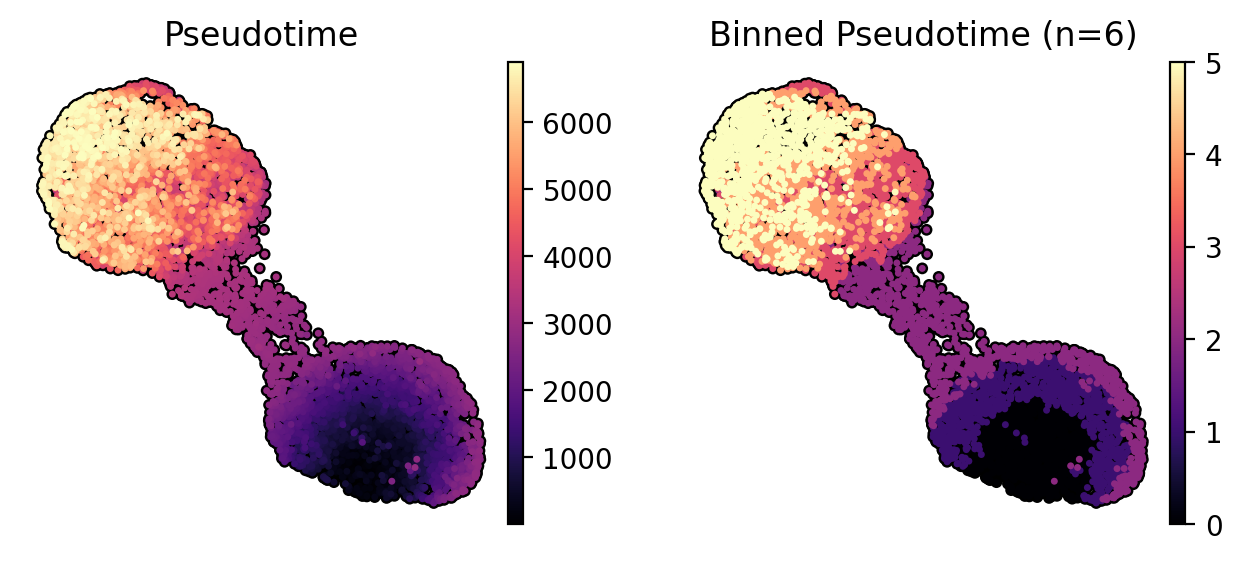

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

n = 6  # number of bins

adata.obs['sample_labels'] = pd.cut(
    adata.obs['global_ordering'],
    bins=n,
    labels=range(n)
).astype(int)

print(adata.obs['sample_labels'].value_counts().to_string())
    
sc.pl.umap(
    adata,
    color=['global_ordering', 'sample_labels'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    cmap='magma',
    title=['Pseudotime', f'Binned Pseudotime ({n=})'],
    frameon=False,
    wspace=0.25,
)

# If by phase 

In [4]:
# label_map = {
#     'G1' : 0,
#     'S' : 1,
#     'G2M' : 2,
# }
# adata.obs['sample_labels'] = adata.obs['cluster_phase'].map(label_map)
# adata.obs['sample_labels'].value_counts()

# Write out

In [6]:
%%time

layer = 'scvi'
outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/TrajNet_input.h5ad"

adata.write(outpath)
adata

CPU times: user 503 ms, sys: 3.83 s, total: 4.33 s
Wall time: 17.6 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra